In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
table1=pd.read_excel('HeatExchangerNetwork.xlsx')
table1.set_index("Stream Number",inplace=True)
table1["Stream Type"]=np.where(table1["Ts"]>table1["Tt"],"HOT","COLD") 
table1["FCp"]=np.where(table1["Stream Type"]=="HOT",table1["FCp"]-(2*table1["FCp"]),table1["FCp"]) 
Tmin=np.linspace(0.5,100,200)
pinch=[]
min_hot_utility=[]
min_cold_utility=[]
for tmin in Tmin:
    table1["Stream Type"]=np.where(table1["Ts"]>table1["Tt"],"HOT","COLD") 
    table1["FCp"]=np.where(table1["Stream Type"]=="HOT",table1["FCp"]-(2*table1["FCp"]),table1["FCp"]) 
    hot_streams=table1[table1["Stream Type"]=="HOT"]
    cold_streams=table1[table1["Stream Type"]=="COLD"]
    temp_left=cold_streams["Ts"].append(cold_streams["Tt"]).append(hot_streams["Ts"]-tmin).append(hot_streams["Tt"]-tmin).sort_values(ascending=False) 
    temp_left=list(dict.fromkeys(temp_left)) #this will drop duplicates
    temp_right=hot_streams["Ts"].append(hot_streams["Tt"]).append(cold_streams["Ts"]+tmin).append(cold_streams["Tt"]+tmin).sort_values(ascending=False) 
    temp_right=list(dict.fromkeys(temp_right)) #this will drop duplicates
    k=[i for i in range(len(temp_right))] 
    problem_table=pd.DataFrame()
    problem_table["Network"]=[i for i in range(len(temp_right))]
    problem_table["Network"]=problem_table["Network"].astype(str)
    problem_table["Sub"]=np.repeat("SN",len(temp_right))
    problem_table['Subnetwork'] = problem_table['Sub']+problem_table["Network"]
    problem_table=problem_table.drop(["Sub","Network"],axis=1)
    problem_table["Tleft"]=temp_left
    problem_table["Tright"]=temp_right
    streams_involved=np.zeros((len(problem_table),len(table1)+1),dtype='int')
    for i in range(len(problem_table)):
        for j in range(len(cold_streams)):
            z=np.where(cold_streams.iloc[j]["Ts"]<=problem_table.iloc[i]["Tleft"]<cold_streams.iloc[j]["Tt"],cold_streams.iloc[j].name,0)
            streams_involved[i][z]=z
        for k in range(len(hot_streams)):
            y=np.where(hot_streams.iloc[k]["Tt"]<=problem_table.iloc[i]["Tright"]<hot_streams.iloc[k]["Ts"],hot_streams.iloc[k].name,0)
            streams_involved[i][y]=y
    problem_table["Streams Involved"]=[streams_involved[i] for i in range(len(problem_table))] 
    difference=[0]
    for i in range(1,len(problem_table)):
        difference.append(problem_table["Tleft"][i-1]-problem_table["Tleft"][i])
    problem_table["Temperature Difference"]=difference
    k=np.zeros(len(problem_table))
    for i in range(len(problem_table)):
        streams=np.extract(problem_table["Streams Involved"][i]!=0, problem_table["Streams Involved"][i]) 
        sum=0
        n=len(streams)
        for n in range(len(streams)):
            sum=sum+table1.loc[streams[n]]["FCp"] 
        k[i]=sum
    problem_table["Summation of FCp"]=k
    problem_table["Deficit"]=problem_table["Summation of FCp"]*problem_table["Temperature Difference"]
    x=[-problem_table["Deficit"].cumsum()[i-1] for i in range(1,len(problem_table))]
    x=np.array(x)
    y=[0]
    y=np.array(y)
    z=np.concatenate((y,x))
    problem_table["Accumulated Input"]=z 
    problem_table["Accumulated Output"]=-problem_table["Deficit"].cumsum() 
    problem_table["Heat Flows Input"]=abs(problem_table["Accumulated Output"].min())+problem_table["Accumulated Input"]
    problem_table["Heat Flows Output"]=abs(problem_table["Accumulated Output"].min())+problem_table["Accumulated Output"] 
    pinch_temp=problem_table[problem_table["Heat Flows Output"]==0.0]["Tright"]
    pinch_temp=pinch_temp.values
    pinch_temp=pinch_temp[0]
    minimum_hot_utility=problem_table.iloc[0]["Heat Flows Input"] 
    minimum_cold_utility=problem_table.iloc[-1]["Heat Flows Output"] 
    pinch.append(pinch_temp)
    min_hot_utility.append(minimum_hot_utility)
    min_cold_utility.append(minimum_cold_utility)

In [3]:
threshold=pd.DataFrame()
threshold["DeltaTmin"]=Tmin
threshold["Pinch Temperature"]=pinch
threshold["Minimum Hot Utility"]=min_hot_utility
threshold["Minimum Cold Utility"]=min_cold_utility

In [4]:
#We are taking only odd entries of the table because even values displayed here are wrong
cold_utility=[]
temp=[]
hot_utility=[]
for n in range(1,201,2):
    cold_utility.append(threshold.iloc[n]["Minimum Cold Utility"])
    hot_utility.append(threshold.iloc[n]["Minimum Hot Utility"])
    temp.append((n+1)/2)

In [5]:
temp=np.array(temp)
temp=temp.reshape(-1,1)  
cold_utility=np.array(cold_utility)
cold_utility=cold_utility.reshape(-1,1) 
hot_utility=np.array(hot_utility)
hot_utility=hot_utility.reshape(-1,1)

In [10]:
def Utility_DeltaTmin_graph():
    plt.figure(figsize=(10,10))
    plt.plot(temp,cold_utility,color='blue',label='Minimum Cold Utility Required')
    plt.plot(temp,hot_utility,color='red',label='Minimum Hot Utility Required')
    plt.plot(temp,cold_utility+hot_utility,color='black',label='Minimum Total Utility Required')
    plt.xlabel("DeltaTmin(°C)")
    plt.ylabel("Utility usage")
    plt.legend()
    plt.show() 

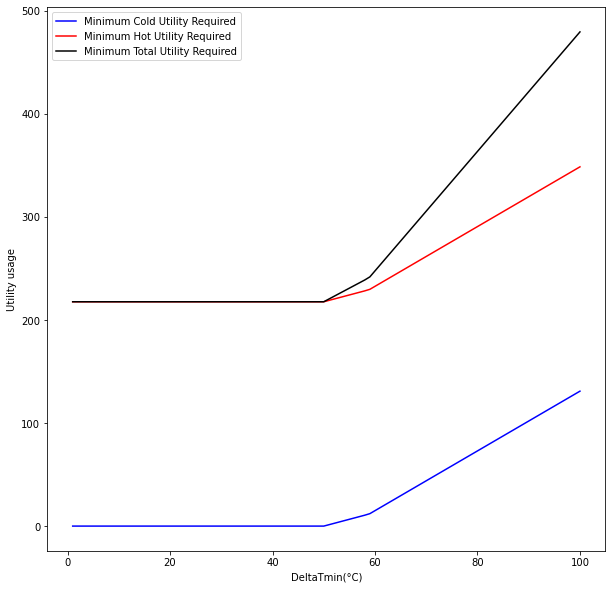

In [11]:
Utility_DeltaTmin_graph()

In [17]:
final_dataframe=threshold.iloc[1::2]
final_dataframe

,DeltaTmin,Pinch Temperature,Minimum Hot Utility,Minimum Cold Utility
1,1.0,101.0,217.553,0.000
3,2.0,102.0,217.553,0.000
5,3.0,103.0,217.553,0.000
7,4.0,104.0,217.553,0.000
9,5.0,105.0,217.553,0.000
...,...,...,...,...
191,96.0,246.0,336.815,119.262
193,97.0,247.0,339.712,122.159
195,98.0,248.0,342.609,125.056
197,99.0,249.0,345.506,127.953


In [18]:
final_dataframe.to_excel("DeltaTmin_vs_MinimumEnergyRequired.xlsx") 